In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import problexity as px

from sklearn.linear_model import LogisticRegression # Works
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Works
from sklearn.neighbors import KNeighborsClassifier # Works
from sklearn.naive_bayes import GaussianNB # Works
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from matplotlib.transforms import Affine2D


from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, specificity_score

import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from numpy import average
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings


le = LabelEncoder()

SEED = 42
DATA_STRUCTURE = json.load(open('data_structure.json'))
DATA_KEYS = list(DATA_STRUCTURE.keys())
CLASSIFIERS = {
  "GaussianNB":GaussianNB,
  "LinearDiscriminantAnalysis":LinearDiscriminantAnalysis,
  "KNeighborsClassifier":KNeighborsClassifier,
  "DecisionTreeClassifier":DecisionTreeClassifier,
  "LogisticRegression": LogisticRegression,
  # "SVC":SVC
  # Random forrest 
}
complexityDFColumns = ['dataset','t1 Complexity','t2 Complexity', 't3 Complexity']
OUTPUT_COLS = ['dataset', 'target', 'target_name', 'avg_precision', 'precision_folds', 'avg_recall', 'recall_folds', 'avg_f1', 'f1_folds', 'avg_geometric_mean', 'geometric_mean_folds','avg_specificity','specificity_folds']

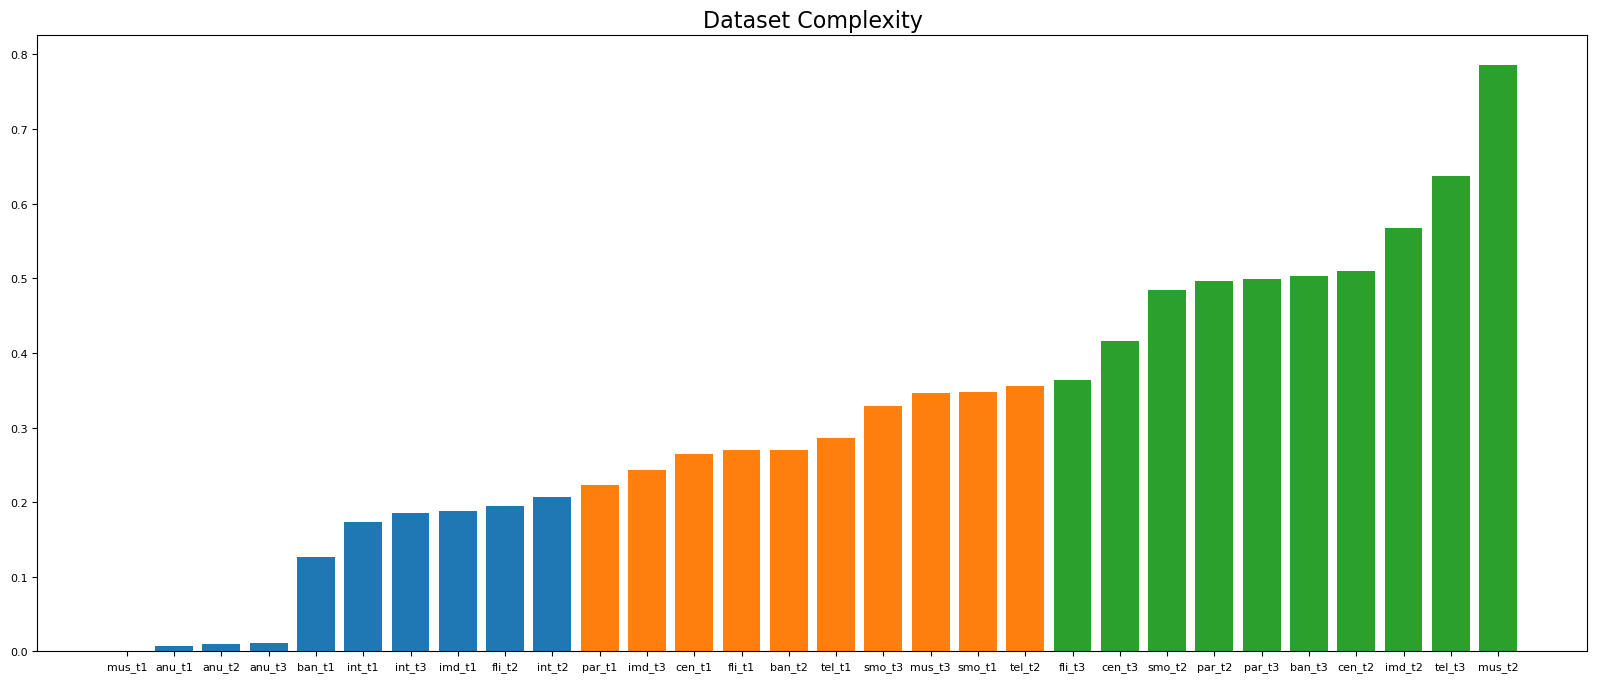

In [2]:
from matplotlib.pyplot import figure

complexityDF = pd.read_csv(f'./out/complexityDF.csv', index_col=0)

complexityDFColumns = ['dataset','target1','target2', 'target3']
complexityDF.columns = complexityDFColumns

meltedComplexityDF = pd.melt(complexityDF, value_vars=['target1','target2', 'target3'], var_name='Target', id_vars=['dataset'])

meltedComplexityDF= meltedComplexityDF.sort_values(by=['value'], ignore_index=True)
chunks = np.array_split(meltedComplexityDF, 3)

finalComplexityDF = pd.DataFrame({})
for i, chunk in enumerate(chunks):
  # print(chunk['Target'].values)
  # print(chunk['dataset'].values)

  chunk['chunk'] = [i]*len(chunk)
  labels = []
  for i in range(len(chunk['Target'].values)):
    labels.append(chunk['dataset'].values[i][0:3] + '_' +  chunk['Target'].values[i][-2:])
  plt.rcParams["figure.figsize"] = (20,8)
  plt.rc('font', size=8) 
  plt.title("Dataset Complexity", size=16)
  plt.bar( labels, chunk['value'].values, width=0.8, bottom=None, align='center', data=None)
  # print('------------------------------------------------')
  finalComplexityDF = pd.concat((finalComplexityDF, chunk))

# print(finalComplexityDF)


['mushroom: Class', 'anuran: Family', 'anuran: Genus', 'anuran: Species', 'bank: y', 'intention: Revenue', 'intention: SpecialDay', 'imdb: imdb_score', 'flight: Customer Type', 'intention: VisitorType', 'paris: category', 'imdb: gross', 'census: income', 'flight: satisfaction', 'bank: loan', 'telco: Churn', 'smoking: dental caries', 'mushroom: habitat', 'smoking: smoking', 'telco: Contract', 'flight: Class', 'census: workclass', 'smoking: tartar', 'paris: isNewBuilt', 'paris: hasStorageRoom', 'bank: housing', 'census: marital-status', 'imdb: content_rating', 'telco: PaymentMethod', 'mushroom: population']


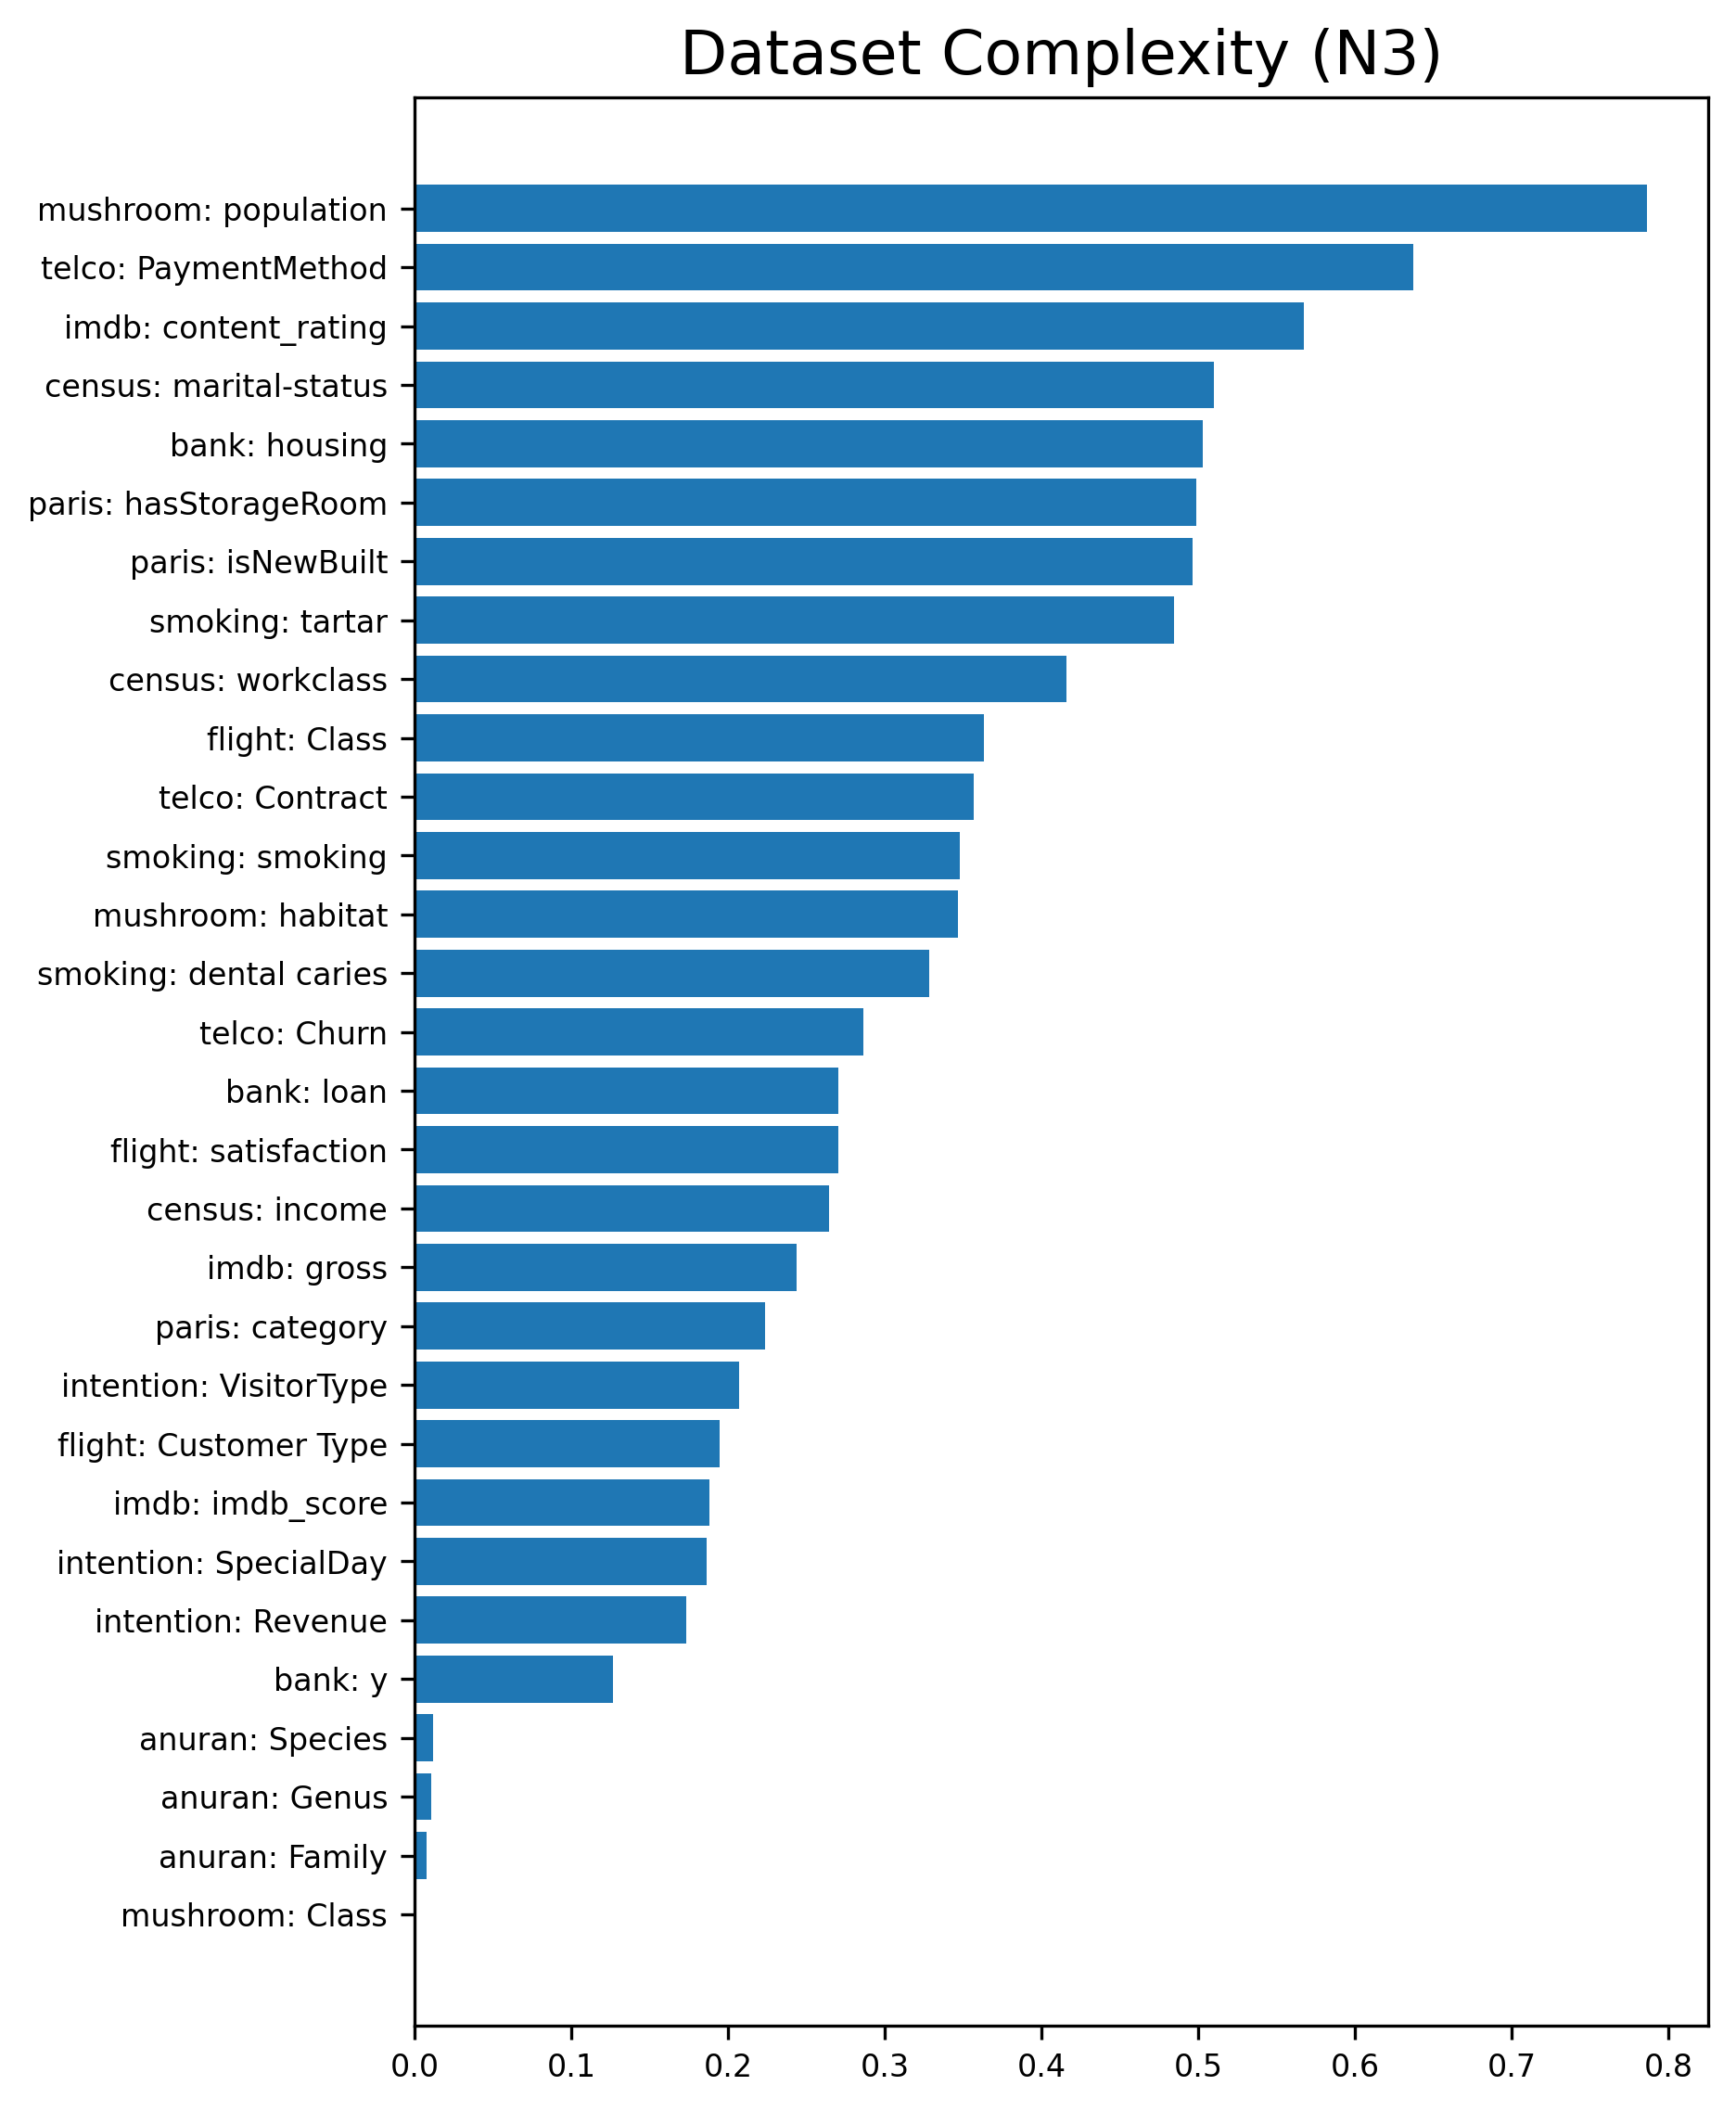

In [4]:
from matplotlib.pyplot import figure

complexityDF = pd.read_csv(f'./out/complexityDF.csv', index_col=0)

complexityDFColumns = ['dataset','target1','target2', 'target3']
complexityDF.columns = complexityDFColumns

meltedComplexityDF = pd.melt(complexityDF, value_vars=['target1','target2', 'target3'], var_name='Target', id_vars=['dataset'])

meltedComplexityDF= meltedComplexityDF.sort_values(by=['value'], ignore_index=True)
chunks = np.array_split(meltedComplexityDF, 3)

finalComplexityDF = pd.DataFrame({})
for i, chunk in enumerate(chunks):
  # print(chunk['Target'].values)
  # print(chunk['dataset'].values)

  chunk['chunk'] = [i]*len(chunk)
  labels = []
  for i in range(len(chunk['Target'].values)):
    labels.append(chunk['dataset'].values[i][0:3] + '_' +  chunk['Target'].values[i][-2:])
  plt.rcParams["figure.figsize"] = (6, 9)
  plt.rc('font', size=8) 
  plt.title("Dataset Complexity (N3)", size=16)
  # plt.bar( labels, chunk['value'].values, width=0.8, bottom=None, align='center', data=None)
  # # print('------------------------------------------------')
  finalComplexityDF = pd.concat((finalComplexityDF, chunk))

# print(finalComplexityDF)

datasetList = list(finalComplexityDF['dataset'].values)
targetList = list(finalComplexityDF['Target'].values)


complexityLabels = []
for i in range(len(datasetList)):
  complexityLabels.append(f'{datasetList[i]}: {DATA_STRUCTURE[datasetList[i]][targetList[i]]}')

print(complexityLabels)
complexityValues = list(finalComplexityDF['value'].values)
plt.rcParams['figure.dpi'] = 500
plt.barh( complexityLabels, complexityValues,align='center', data=None)
plt.savefig(f'./figures/complexity.png',bbox_inches='tight') 


In [ ]:
def get_data(name):
  orderedcomplexity = finalComplexityDF[finalComplexityDF['dataset']==name].sort_values(by=['value'])['Target'].values
  if name == 'imdb':
    movie_data = pd.read_csv('./Datasets/movie_metadata.csv')
    movie_data.drop_duplicates(inplace=True)
    movie_data.loc[:,'genres'] = movie_data.loc[:,'genres'].apply(lambda x: x.split('|'))

    genres = []
    for x in movie_data.genres:
      for g in x:
        if g not in genres:
          genres.append(g)

    for g in genres:
      movie_data.loc[:,g] = movie_data.loc[:,'genres'].apply(lambda x: int(g in x))

    movie_data.drop(["director_name","actor_2_name","movie_title","genres","actor_1_name","actor_3_name","plot_keywords","movie_imdb_link","cast_total_facebook_likes"],axis=1, inplace = True)
    movie_data.dropna(inplace=True)

    movie_data["imdb_score"] = movie_data["imdb_score"].apply(float)
    movie_data.loc[movie_data['imdb_score'].between(8,10), 'imdb_score'] = 100.0
    movie_data.loc[movie_data['imdb_score'].between(5,7.99), 'imdb_score'] = 50.0
    movie_data.loc[movie_data['imdb_score'].between(0,4.992), 'imdb_score'] = 30.0
    movie_data["imdb_score"] = movie_data["imdb_score"].apply(str)
    movie_data.loc[movie_data['imdb_score'] == "100.0", 'imdb_score'] = "GOOD"
    movie_data.loc[movie_data['imdb_score'] == "50.0", 'imdb_score'] = "AVERAGE"
    movie_data.loc[movie_data['imdb_score'] == "30.0", 'imdb_score'] = "BAD"

    ratings = movie_data["content_rating"].unique()
    for rate in ratings:
        if rate == "M":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "GP":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "Unrated":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Not Rated"
        elif rate == "Passed":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Approved"
        elif rate == "X":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "NC-17"

    movie_data.loc[movie_data['gross'].between(0,15000000.0), 'gross'] = 0.0
    movie_data.loc[movie_data['gross'].between(1500000.01,762000000.0), 'gross'] = 1.0
    movie_data = pd.get_dummies(movie_data,columns=['color','language','country'],drop_first=True)

    target1 = le.fit_transform(movie_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(movie_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(movie_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    
    X_final = movie_data.drop(["imdb_score", "content_rating", "gross"],axis=1)

  elif name == 'mushroom':
    mushroom_data = pd.read_csv('./Datasets/mushroom.csv')
    mushroom_data = mushroom_data[mushroom_data['stalk-root']!='?']
    mushroom_data = pd.get_dummies(mushroom_data,columns=['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
          'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
          'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
          'stalk-surface-below-ring', 'stalk-color-above-ring',
          'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
          'ring-type', 'spore-print-color'],drop_first=True)
    target1 = le.fit_transform(mushroom_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(mushroom_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(mushroom_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = mushroom_data.drop(["Class", "population", "habitat"],axis=1)
  
  elif name == 'census':
    census_data = pd.read_csv('./Datasets/census.csv',names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']) 
    census_data=census_data.drop_duplicates()
    for col in census_data.columns:
      census_data = census_data[census_data[col]!=' ?']
    census_data.loc[census_data.income==' <=50K.','income'] = ' <=50K' 
    census_data.loc[census_data.income==' >50K.','income'] = ' >50K'
    census_data = pd.get_dummies(census_data,columns=['education','occupation','relationship','race','sex','native-country'],drop_first=True)
    target1 = le.fit_transform(census_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(census_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(census_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = census_data.drop(["income", "marital-status", "workclass"],axis=1)
  
  elif name == 'bank':
    bank_data = pd.read_csv('./Datasets/bank-additional.csv')
    for col in bank_data.columns:
      bank_data = bank_data[bank_data[col]!='unknown']
    bank_data = pd.get_dummies(bank_data,columns=['job','education','default','contact','month','day_of_week','poutcome','marital'],drop_first=True)
    target1 = le.fit_transform(bank_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(bank_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(bank_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = bank_data.drop(["y", "loan", "housing"],axis=1)

  elif name == 'intention':
    intention_data = pd.read_csv('./Datasets/online_shoppers_intention.csv')
    intention_data = intention_data.drop_duplicates()
    intention_data = intention_data[intention_data['VisitorType']!='Other']
    intention_data = pd.get_dummies(intention_data,columns=['Month','Weekend'],drop_first=True)        
    target1 = le.fit_transform(intention_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(intention_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(intention_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = intention_data.drop(["Revenue", "VisitorType", "SpecialDay"],axis=1)

  elif name == 'anuran':
    anuran_data = pd.read_csv('./Datasets/Frogs_MFCCs.csv')
    anuran_data.drop(columns='RecordID',inplace=True)
    target1 = le.fit_transform(anuran_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(anuran_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(anuran_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = anuran_data.drop(["Family", "Genus", "Species"],axis=1)
  
  elif name == 'telco':
    telco_data = pd.read_csv('./Datasets/telco.csv')
    telco_data.drop(columns=['customerID'],inplace=True)
    telco_data = telco_data.drop_duplicates()
    telco_data = telco_data[telco_data.TotalCharges!=' ']
    telco_data = pd.get_dummies(telco_data,columns=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling'],drop_first=True)
    target1 = le.fit_transform(telco_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(telco_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(telco_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = telco_data.drop(["Churn", "Contract", "PaymentMethod"],axis=1)

  elif name == 'paris':
    paris_data = pd.read_csv('./Datasets/ParisHousingClass.csv')
    paris_data.drop(columns='made',inplace=True)
    target1 = le.fit_transform(paris_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(paris_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(paris_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = paris_data.drop(["category", "isNewBuilt", "hasStorageRoom"],axis=1)
  
  elif name == 'smoking':
    smoking_data = pd.read_csv('./Datasets/smoking.csv')
    smoking_data.drop(columns=['ID','oral'],inplace=True)
    smoking_data = smoking_data.drop_duplicates()
    smoking_data = pd.get_dummies(smoking_data,columns=['gender'],drop_first=True)
    target1 = le.fit_transform(smoking_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(smoking_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(smoking_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = smoking_data.drop(["smoking", "tartar", "dental caries"],axis=1)
  
  elif name == 'flight':
    flight_data = pd.read_csv('./Datasets/flight.csv')
    flight_data.dropna(inplace=True)
    flight_data = pd.get_dummies(flight_data,columns=['Gender','Type of Travel'],drop_first=True)
    target1 = le.fit_transform(flight_data[DATA_STRUCTURE[name][orderedcomplexity[0]]])
    target2 = le.fit_transform(flight_data[DATA_STRUCTURE[name][orderedcomplexity[1]]])
    target3 = le.fit_transform(flight_data[DATA_STRUCTURE[name][orderedcomplexity[2]]])
    X_final = flight_data.drop(["satisfaction", "Customer Type", "Class"],axis=1)
  
  else:
    raise ValueError('Incorrect dataset')
  
  return X_final, target1, target2, target3

In [ ]:
print(get_data('census')[2])

In [ ]:
def plotDist(arr, title):
  values, counts = np.unique(arr, return_counts=True)
  lis = np.asarray((values, counts)).T
  x, y = zip(*lis) # unpack a list of pairs into two tuples
  # plt.plot(x, y)
  plt.bar(x,y)

  plt.title(title)
  # plt.show()

plt.figure(figsize=(20, 50), dpi=80)

for i in range(len(DATA_STRUCTURE)):
  key = DATA_KEYS[i]
  dataSet = DATA_STRUCTURE[key]
  target, t1, t2, t3 = get_data(key)
  plt.subplot(10, 3, i*3+1)
  plotDist(t1, dataSet['target1'])
  plt.subplot(10, 3, i*3+2)
  plotDist(t2, dataSet['target2'])
  plt.subplot(10,3, i*3+3)
  plotDist(t3, dataSet['target3'])
plt.show()

In [ ]:
warnings.filterwarnings('ignore')

complexityDF = pd.DataFrame({}, columns=complexityDFColumns)
print(complexityDF)
for i in range(len(DATA_STRUCTURE)):
  key = DATA_KEYS[i]
  print(key)
  dataSet = DATA_STRUCTURE[key]
  features, t1, t2, t3 = get_data(key)
  t1n3 = px.n3(features, t1)
  print('t1 done')
  t2n3 = px.n3(features, t2)
  print('t2 done')
  t3n3 = px.n3(features, t3)
  print('t3 done')
  pdRow = pd.DataFrame([key, t1n3,t2n3,t3n3]).T
  print(pdRow)
  pdRow.columns = complexityDFColumns
  complexityDF = pd.concat([complexityDF,pdRow], axis=0, ignore_index=True)
print(complexityDF)
complexityDF.to_csv(path_or_buf=f'./out/complexityDF.csv')

In [ ]:
complexityDF = pd.read_csv(f'./out/complexityDF.csv', index_col=0)

plt.figure( dpi=100)

fig, axs = plt.subplots(4,3, constrained_layout=True)
fig.set_size_inches(10,10)
fig.suptitle('N3 Data Complexity Measures', fontsize=32, y=1.2)
fig.set_figwidth(30)
fig.set_figheight(8)

# complexityDFColumns = ['dataset','t1 Complexity','t2 Complexity', 't3 Complexity', 'multiclass Complexity']

for row, data in complexityDF.iterrows():
  axs[row//3, row%3].bar(complexityDFColumns[1:],data.values[1:], capsize=6)
  axs[row//3, row%3].set_title(f'{data[0]}')


# Arranging Datasets based on complexity

In [ ]:
tmp = finalComplexityDF.groupby('dataset')['value'].max() + finalComplexityDF.groupby('dataset')['value'].mean()
tmp = tmp.to_frame()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ['dataset', 'value']
tmp = tmp.sort_values(by='value')

print(tmp)

plt.rc('font', size=14) 
plt.bar( tmp['dataset'], tmp['value'].values, width=0.8, bottom=None, align='center', data=None)


# Other stuff

In [ ]:
for classifier in CLASSIFIERS:
  original = pd.read_csv(f'out/{classifier}.csv', index_col=0)
  original = original.sort_values(by=['dataset', 'target'], ignore_index=True)
  original['complexity']= finalComplexityDF.sort_values(by=['dataset', 'Target'], ignore_index=True)['chunk']
  original.to_csv(path_or_buf=f'./out/{classifier}.csv')

  

In [ ]:
complexities = ['Low Complexity','Medium Complexity','High Complexity']
aggregateMetrics = {}
aggregateStandardDev = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/{name}.csv')
  # print(df.columns)
  result = df.groupby('complexity')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()

  standardDev = df.groupby('complexity')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  
  aggregateStandardDev[name] = standardDev
  aggregateMetrics[name] = result

allAggregatePerformances = {
  "Original": (aggregateMetrics,aggregateStandardDev, 'bo')}

In [ ]:

plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for learner in learners:
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=32, y=1.2)
  fig.set_figwidth(30)
  fig.set_figheight(8)

  loc = ticker.MultipleLocator(base=2.5) # this locator puts ticks at regular intervals

  # Iterate through the 3 targets
  for i in range(3):

    for j, AggregatePerformance in enumerate(allAggregatePerformances):
      curr = allAggregatePerformances[AggregatePerformance]
      performance = curr[0][learner].iloc[i].values
      performanceStandardDev = curr[1][learner].iloc[i].values
      axs[i].set(xmargin= 0.1, ylim=(0, 1))
      axs[i].errorbar(metrics, performance, fmt=curr[2],yerr=performanceStandardDev, linewidth=1, capsize=6, label=AggregatePerformance)

    axs[i].set_title(f'{complexities[i]}',fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
  handles, labels = axs[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper left', fontsize='xx-large')
plt.show()

## Baseline classification with targets selected based on complexity

In [ ]:
def shuffle(df, t1, t2, t3):
  df['t1'] = t1.tolist()
  df['t2'] = t2.tolist()
  df['t3'] = t3.tolist()
  # use Seed
  shuffledDf = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
  shuffledT1 = shuffledDf['t1']
  shuffledT2 = shuffledDf['t2']
  shuffledT3 = shuffledDf['t3']

  shuffledDf = shuffledDf.drop(['t1','t2','t3'], 1)
  return shuffledDf, shuffledT1, shuffledT2, shuffledT3

def split(df, t1, t2, t3, k):
  targets = np.vstack((t1, t2,t3)).T
  chunks = np.array_split(df, k)
  classes = np.array_split(targets, k)
  return chunks, classes


from numpy import average
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore') 

# Because Scikit-learn's multi output classifier doesn't support metrics for multi label classification, we implemented our own.
def crossValidate(classifier, df, t1, t2, t3, k, dataSetName):
  df, t1, t2, t3 = shuffle(df, t1, t2, t3)
  # Split the data and classes into k subsets
  data, classes = split(df, t1, t2, t3, k)
  foldResults = {
    'target1' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
      
    },
    'target3' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target2' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    }
  }

  for i in range(k):
    # use the data at position i as the test data
    testData = data[i]
    testClasses = classes[i]

    # use the data at all positions other than i as the train data
    trainData = pd.concat((data[:i] + data[i+1:]))
    trainclasses = np.concatenate((classes[:i] + classes[i+1:]))
    
    # Create a multioutput classifier from the provided classifier
    clf = MultiOutputClassifier(classifier())

    

    # Fit the model to Training data
    clf.fit(trainData, trainclasses)

    # Use the model on the test data
    testResults = clf.predict(X=testData)

    # Since the results for multi label classification come as a list of size (n, 3), decompose the list into the results for each target
    t1Results = testResults[:, 0]
    t2Results = testResults[:, 1]
    t3Results = testResults[:, 2]

    # Do the same for the actual classes
    t1Classes = testClasses[:, 0]
    t2Classes = testClasses[:, 1]
    t3Classes = testClasses[:, 2]

    actualVsPredicted = {
      'target1':(t1Classes, t1Results),
      'target2':(t2Classes, t2Results),
      'target3':(t3Classes, t3Results)
    }
    for target in actualVsPredicted:
      (actual, predicted) = actualVsPredicted[target]
      # Calculate the scores for each metric
      prec_macro = precision_score(actual, predicted, average='macro', zero_division=0)
      recall_macro = recall_score(actual, predicted, average="macro", zero_division=0)
      f1_macro = f1_score(actual, predicted, average='macro')
      geometric_mean = geometric_mean_score(actual, predicted)
      specificity = specificity_score(actual, predicted, average='macro')

      # Add the scores for the current train/test split to the list of other scores for the respective target
      foldResults[target]['precScores'].append(prec_macro)
      foldResults[target]['recallScores'].append(recall_macro)
      foldResults[target]['f1Scores'].append(f1_macro)
      foldResults[target]['geometricMeanScores'].append(geometric_mean)
      foldResults[target]['specificityScores'].append(specificity)
  

  df = pd.DataFrame(columns=OUTPUT_COLS)
  for target in foldResults:
    stats = foldResults[target]
    row = [dataSetName, target,DATA_STRUCTURE[dataSetName][target]]
    for stat in stats:
      row.append(average(stats[stat]))
      row.append(stats[stat])
    pdRow = pd.DataFrame(row).T
    pdRow.columns = OUTPUT_COLS
    df = pd.concat([df,pdRow], axis=0, ignore_index=True)
  return df

aggregateMetrics = {}

for name in CLASSIFIERS:
  print(name+ ': Starting')
  outputDf = pd.DataFrame()
  for i in range(len(DATA_STRUCTURE)):
    if i < 80:
      print('   '+ DATA_KEYS[i] + ': starting')
      df, target1, target2, target3 = get_data(DATA_KEYS[i] )
      outputDf = pd.concat([outputDf, crossValidate(CLASSIFIERS[name],df, target1, target2, target3, 5, DATA_KEYS[i])], ignore_index=True)
    # print(outputDf)
  print(name+ ': done')
  print('The average of each metric after cross validation per target across all data sets')
  result = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean','avg_specificity'].mean()
  print(result)
  aggregateMetrics[name] = result
  outputDf.to_csv(path_or_buf=f'./out/{name}.csv')
  

In [ ]:
# Only on train
# Naive Approach: Look at target variable that is performing worst, try to do something about that variable only
# Generate features, but also other target values - Add other targets as features.. Make sure to remove them before training
# Use modified data to train 

# imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler

plt.figure(figsize=(20, 50), dpi=80)
def crossValidateSmote(classifier, df, t1, t2, t3, k, dataSetName):
  df, t1, t2, t3 = shuffle(df, t1, t2, t3)
  # Split the data and classes into k subsets
  data, classes = split(df, t1, t2, t3, k)
  foldResults = {
    'target1' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target3' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target2' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    }
  }
  for i in range(k):
    # use the data at position i as the test data
    testData = data[i]
    testClasses = classes[i]

    # use the data at all positions other than i as the train data
    trainData = pd.concat((data[:i] + data[i+1:]))
    trainClasses = np.concatenate((classes[:i] + classes[i+1:]))

    t1Class = trainClasses[:, 0]
    t2Class = trainClasses[:, 1]
    t3Class = trainClasses[:, 2]

    # Apply SMOTE to the training data
    testDataCombined = combine(trainData, t1Class, t2Class, t3Class).drop(['t1'], 1)

    sm = SMOTE(random_state=SEED, sampling_strategy='not majority')
    us = RandomUnderSampler(random_state=SEED)
    # sm = CondensedNearestNeighbour(random_state=SEED)
    # sm = RandomOverSampler(random_state=SEED, sampling_strategy=0.5)
    # sm = RandomOverSampler(random_state=SEED, sampling_strategy='not majority')

    reSampled_df, resampled_target1 = sm.fit_resample(testDataCombined, t1Class)
    reSampled_df, resampled_target1 = us.fit_resample(reSampled_df, resampled_target1)
    resampled_target2 = reSampled_df['t2']
    resampled_target3 = reSampled_df['t3']
    reSampled_df = reSampled_df.drop(['t2','t3'], 1)

    # plt.subplot(10, 2, i*2+1)
    # plotDist(t1, f'{dataSetName}: cross{i}: Old Distribution')
    # plt.subplot(10, 2, i*2+2)
    # plotDist(resampled_target1,  f'{dataSetName}: cross{i}: New Distribution')

    # Build the training outpus classes using the resampled target1 values (generated as classes), and the target2 and target3 values (generated as features) from smote 
    resampledTrainClasses = np.vstack((resampled_target1, resampled_target2,resampled_target3)).T
  
    # Create a multioutput classifier from the provided classifier
    clf = MultiOutputClassifier(classifier())

    # Fit the model to Training data
    clf.fit(reSampled_df, resampledTrainClasses)

    # Use the model on the test data
    testResults = clf.predict(X=testData)
    # Since the results for multi label classification come as a list of size (n, 3), decompose the list into the results for each target
    t1Results = testResults[:, 0]
    t2Results = testResults[:, 1]
    t3Results = testResults[:, 2]

    # Do the same for the actual classes
    t1Classes = testClasses[:, 0]
    t2Classes = testClasses[:, 1]
    t3Classes = testClasses[:, 2]

    actualVsPredicted = {
      'target1':(t1Classes, t1Results),
      'target2':(t2Classes, t2Results),
      'target3':(t3Classes, t3Results)
    }
    for target in actualVsPredicted:
      (actual, predicted) = actualVsPredicted[target]
      # Calculate the scores for each metric
      prec_macro = precision_score(actual, predicted, average='macro', zero_division=0)
      recall_macro = recall_score(actual, predicted, average="macro", zero_division=0)
      f1_macro = f1_score(actual, predicted, average='macro')
      geometric_mean = geometric_mean_score(actual, predicted)
      specificity = specificity_score(actual, predicted, average='macro')
      # Geometric means

      # Add the scores for the current train/test split to the list of other scores for the respective target

      # 3 targets

      # Add the scores for the current train/test split to the list of other scores for the respective target
      foldResults[target]['precScores'].append(prec_macro)
      foldResults[target]['recallScores'].append(recall_macro)
      foldResults[target]['f1Scores'].append(f1_macro)
      foldResults[target]['geometricMeanScores'].append(geometric_mean)
      foldResults[target]['specificityScores'].append(specificity)

      # 'avg_specificity','specificity_folds'

  df = pd.DataFrame(columns=OUTPUT_COLS)
  # print(len(OUTPUT_COLS))
  for target in foldResults:
    stats = foldResults[target]
    row = [dataSetName,target, DATA_STRUCTURE[dataSetName][target]]
    for stat in stats:
      row.append(average(stats[stat]))
      row.append(stats[stat])
    pdRow = pd.DataFrame(row).T
    pdRow.columns = OUTPUT_COLS
    df = pd.concat([df,pdRow], axis=0, ignore_index=True)
  # print(df)
  return df

def combine(df, t1, t2,t3):
  df['t1'] = t1.tolist()
  df['t2'] = t2.tolist()
  df['t3'] = t3.tolist()
  return df


aggregateMetricsAdjusted = {}
for name in CLASSIFIERS:
  print(name+ ': Starting')
  outputDf = pd.DataFrame()
  print(len(DATA_STRUCTURE))
  for i in range(len(DATA_STRUCTURE)):
    print('   '+ DATA_KEYS[i] + ': starting')
    df, target1, target2, target3 = get_data(DATA_KEYS[i])
    outputDf = pd.concat([outputDf, crossValidateSmote(CLASSIFIERS[name],df, target1, target2, target3, 5, DATA_KEYS[i])], ignore_index=True)
    # print(outputDf)
    
  print(name+ ': done')
  print('The average of each metric after cross validation per target across all data sets')
  result = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean', 'avg_specificity'].mean()
  aggregateMetricsAdjusted[name] = result
  outputDf.to_csv(path_or_buf=f'./out/balanced/{name}.csv')

In [ ]:
aggregateMetrics = {}
aggregateStandardDev = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()

  standardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  
  aggregateStandardDev[name] = standardDev
  aggregateMetrics[name] = result

aggregateMetricsAdjustedt1 = {}
aggregateStandardDevAdjustedt1 = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].mean()
  adjustedStandardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()

  aggregateMetricsAdjustedt1[name] = result
  aggregateStandardDevAdjustedt1[name] = adjustedStandardDev


aggregateMetricsAdjustedAllMetrics = {}
aggregateStandardDevAdjustedAllMetrics = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-all-targets/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].mean()
  adjustedStandardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()

  aggregateMetricsAdjustedAllMetrics[name] = result
  aggregateStandardDevAdjustedAllMetrics[name] = adjustedStandardDev

allAggregatePerformances = {
  "Original": (aggregateMetrics,aggregateStandardDev, 'bo'),
  "Adjusted for target 1": (aggregateMetricsAdjustedt1, aggregateStandardDevAdjustedt1, 'ro'),
  "Adjusted for all targets": (aggregateMetricsAdjustedAllMetrics, aggregateStandardDevAdjustedAllMetrics, 'go')
}

In [ ]:
allAggregatePerformances = {
  "Original": (aggregateMetrics,aggregateStandardDev, 'bo'),
  "Adjusted for target 1": (aggregateMetricsAdjustedt1, aggregateStandardDevAdjustedt1, 'ro'),
  "Adjusted for all targets": (aggregateMetricsAdjustedAllMetrics, aggregateStandardDevAdjustedAllMetrics, 'go')
}

plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for learner in learners:
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=32, y=1.2)
  fig.set_figwidth(30)
  fig.set_figheight(8)

  loc = ticker.MultipleLocator(base=2.5) # this locator puts ticks at regular intervals

  # Iterate through the 3 targets
  for i in range(3):

    for j, AggregatePerformance in enumerate(allAggregatePerformances):
      curr = allAggregatePerformances[AggregatePerformance]
      performance = curr[0][learner].iloc[i].values
      performanceStandardDev = curr[1][learner].iloc[i].values
      transformation = Affine2D().translate(0.2*j, 0.0) + axs[i].transData
      axs[i].set(xmargin= 0.1, ylim=(0, 1))
      axs[i].errorbar(metrics, performance, fmt=curr[2],yerr=performanceStandardDev, linewidth=1, capsize=6, transform=transformation, label=AggregatePerformance)
      print(curr[2])
    axs[i].set_title(f'Target {i+1}',fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
  handles, labels = axs[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper left', fontsize='xx-large')
plt.show()